In [1]:
import pandas as pd
import numpy as np
import ast

# 单步法按batch合并数据

In [2]:
data = pd.read_excel('./data_stage2/vis_single_step_attack_100/vis_one_step_sample100_0920.xlsx')
print(data.shape)
data.head()

(33, 15)


model  algo mask_mode  parameter   eta  pixel_attacked  \
0  vit_b_16  fgsm  positive        NaN  0.01           75234   
1  vit_b_16  fgsm  negative        NaN  0.01           75293   
2  vit_b_16  fgsm       all        NaN  0.01          150528   
3  vit_b_16  fgsm      topr       0.15  0.01           22579   
4  vit_b_16  fgsm      lowr       0.85  0.01          127948   

  attack_ratio_per_channel  l1_norm   l2_norm  success_rate  original_loss  \
0      [0.501, 0.499, 0.5]  36.1188  0.004920          0.24         -0.119   
1      [0.499, 0.501, 0.5]  36.2933  0.004947          0.25         -0.119   
2          [1.0, 1.0, 1.0]  72.4121  0.009866          0.49         -0.119   
3     [0.145, 0.185, 0.12]  42.4972  0.009340          0.25         -0.119   
4     [0.855, 0.815, 0.88]  29.9141  0.000526          0.24         -0.119   

   attack_loss  run_time  batch_idx  batch_pictures  
0       -0.824    40.527          1             100  
1       -0.826    42.415          1             100  
2       -1.741    39.785          1             100  
3       -0.771    38.768          1             100  
4       -0.806    42.472          1             100

In [3]:
def mean_of_lists(series):
    # 将每个元素转换为 NumPy 数组，然后计算均值
    arrays = np.array(series.tolist(), dtype=float)
    return np.mean(arrays, axis=0).tolist()

def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    data['attack_ratio_per_channel'] = data['attack_ratio_per_channel'].apply(ast.literal_eval)
    li = ['model', 'algo', 'mask_mode', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'pixel_attacked': lambda x: int(x.mean()),
        'attack_ratio_per_channel': mean_of_lists,
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'original_loss'	: 'mean',
        'attack_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
        'batch_pictures': 'sum', 
    }).reset_index()
    data_grouped[['R', 'G', 'B']] = pd.DataFrame(data_grouped['attack_ratio_per_channel'].tolist(), index=data_grouped.index)
    data_grouped.drop('attack_ratio_per_channel', axis=1, inplace=True)
    return data_grouped

In [4]:
data_grouped = merge_batch_onestep(data)
print(data_grouped.shape)

(33, 16)


In [16]:
# 取model = vit, algo = 'fgsm', eta = 0.01, mask_mode in 'topr', 'lowr'
data_grouped1 = data_grouped[(data_grouped['model'] == 'vit_b_16') & (data_grouped['algo'] == 'fgsm') & (data_grouped['eta'] == 0.01) & (data_grouped['mask_mode'].isin(['topr', 'lowr']))]
data_grouped1

model  algo mask_mode  parameter   eta  pixel_attacked   l1_norm  \
24021  vit_b_16  fgsm      lowr       0.01  0.01            1505    0.0275   
24041  vit_b_16  fgsm      lowr       0.02  0.01            3010    0.1097   
24061  vit_b_16  fgsm      lowr       0.03  0.01            4515    0.2474   
24081  vit_b_16  fgsm      lowr       0.04  0.01            6021    0.4400   
24101  vit_b_16  fgsm      lowr       0.05  0.01            7526    0.6876   
...         ...   ...       ...        ...   ...             ...       ...   
29901  vit_b_16  fgsm      topr       0.95  0.01          143001  842.9550   
29921  vit_b_16  fgsm      topr       0.96  0.01          144506  843.2028   
29941  vit_b_16  fgsm      topr       0.97  0.01          146012  843.3954   
29961  vit_b_16  fgsm      topr       0.98  0.01          147517  843.5328   
29981  vit_b_16  fgsm      topr       0.99  0.01          149022  843.6154   

       l2_norm  original_loss  attack_loss  success_rate  run_time  \
24021  0.00000        -0.1441      -0.1441         0.000    66.074   
24041  0.00000        -0.1441      -0.1442         0.001    64.651   
24061  0.00000        -0.1441      -0.1444         0.001    64.934   
24081  0.00000        -0.1441      -0.1449         0.001    65.418   
24101  0.00000        -0.1441      -0.1451         0.001    65.298   
...        ...            ...          ...           ...       ...   
29901  0.48014        -0.1441      -1.6445         0.444    69.163   
29921  0.48014        -0.1441      -1.6453         0.444    67.737   
29941  0.48014        -0.1441      -1.6457         0.444    68.080   
29961  0.48014        -0.1441      -1.6461         0.444    69.047   
29981  0.48014        -0.1441      -1.6462         0.444    69.559   

       batch_pictures     R       G       B  
24021            1000  0.01  0.0080  0.0119  
24041            1000  0.02  0.0170  0.0230  
24061            1000  0.03  0.0250  0.0350  
24081            1000  0.04  0.0339  0.0461  
24101            1000  0.05  0.0420  0.0580  
...               ...   ...     ...     ...  
29901            1000  0.95  0.9580  0.9420  
29921            1000  0.96  0.9661  0.9539  
29941            1000  0.97  0.9750  0.9650  
29961            1000  0.98  0.9830  0.9770  
29981            1000  0.99  0.9920  0.9880  

[198 rows x 16 columns]

In [6]:
data_grouped.to_excel('./data_stage2/vis_single_step_attack_100/vis_one_step_sample100_0920_grouped.xlsx', index=False)

# 结果分析

In [2]:
data_grouped = pd.read_excel('data_stage2/one_step_attack_total1000_0914/one_step_attack_total1000_0919_loss_grouped.xlsx')

In [3]:
data_root = 'data_stage2/one_step_attack_total1000_0914'

In [14]:
data_grouped_vit = data_grouped[data_grouped

model  algo mask_mode  parameter    eta  pixel_attacked    l1_norm  \
0  resnet50  fgsm       all       -1.0  0.005          150528  1218.0762   
1  resnet50  fgsm       all       -1.0  0.010          150528  1218.0762   
2  resnet50  fgsm       all       -1.0  0.015          150528  1218.0762   
3  resnet50  fgsm       all       -1.0  0.020          150528  1218.0762   
4  resnet50  fgsm       all       -1.0  0.025          150528  1218.0762   

   l2_norm  original_loss  attack_loss  success_rate  run_time  \
0  0.04611        -0.1075      -1.5575         0.438    10.951   
1  0.04611        -0.1075      -2.9247         0.660    10.951   
2  0.04611        -0.1075      -3.8131         0.760    10.951   
3  0.04611        -0.1075      -4.3845         0.822    10.951   
4  0.04611        -0.1075      -4.7609         0.853    10.951   

   batch_pictures    R    G    B  
0            1000  1.0  1.0  1.0  
1            1000  1.0  1.0  1.0  
2            1000  1.0  1.0  1.0  
3            1000  1.0  1.0  1.0  
4            1000  1.0  1.0  1.0

In [3]:
for column in data_grouped.columns:
    if column not in ('l1_norm', 'l2_norm', 'success_rate','pixel_attacked', 'run_time',  'R', 'G', 'B'):
        unique_values = data_grouped[column].unique()
        print(f"字段 '{column}' 的唯一值: {unique_values}")
print(data_grouped.columns)


字段 'model' 的唯一值: ['resnet50' 'vgg16' 'vit_b_16']
字段 'algo' 的唯一值: ['fgsm' 'gaussian_noise']
字段 'mask_mode' 的唯一值: ['all' 'cam_lowr' 'cam_topr' 'lowr' 'negative' 'positive' 'randomr' 'topr']
字段 'parameter' 的唯一值: [-1.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59
  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71
  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83
  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95
  0.96  0.97  0.98  0.99]
字段 'eta' 的唯一值: [0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]
字段 'original_loss' 的唯一值: [-0.1075 -0.161  -0

# 画图分析

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import math
from sklearn.linear_model import LinearRegression

In [5]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print("Available fonts:", font_list)

# 使用第一个找到的中文字体
font_path = next((f for f in font_list if 'SimHei' in f or 'SimSun' in f or 'wqy' in f), None)

Available fonts: ['/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf', '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf']


In [6]:
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'  # 显示中文字体

if not os.path.exists(font_path):
    print(f"字体文件 {font_path} 未找到。请确保字体文件存在于工作目录中。")
else:
    # 创建FontProperties对象
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()


## 1. success_rate vs model&algo
- 只考虑mask_mode in ('all','negative','positive')

In [10]:
data1 = data_grouped[data_grouped['mask_mode'].isin(['all','negative','positive'])]
data1.head()

model  algo mask_mode  parameter    eta  pixel_attacked    l1_norm  \
0  resnet50  fgsm       all       -1.0  0.005          150528  1218.0762   
1  resnet50  fgsm       all       -1.0  0.010          150528  1218.0762   
2  resnet50  fgsm       all       -1.0  0.015          150528  1218.0762   
3  resnet50  fgsm       all       -1.0  0.020          150528  1218.0762   
4  resnet50  fgsm       all       -1.0  0.025          150528  1218.0762   

   l2_norm  original_loss  attack_loss  success_rate  run_time  \
0  0.04611        -0.1075      -1.5575         0.438    10.951   
1  0.04611        -0.1075      -2.9247         0.660    10.951   
2  0.04611        -0.1075      -3.8131         0.760    10.951   
3  0.04611        -0.1075      -4.3845         0.822    10.951   
4  0.04611        -0.1075      -4.7609         0.853    10.951   

   batch_pictures    R    G    B  
0            1000  1.0  1.0  1.0  
1            1000  1.0  1.0  1.0  
2            1000  1.0  1.0  1.0  
3            1000  1.0  1.0  1.0  
4            1000  1.0  1.0  1.0

### 1.1 成功率 and  loss vs eta

In [44]:
from tools.show_result_one_step import *

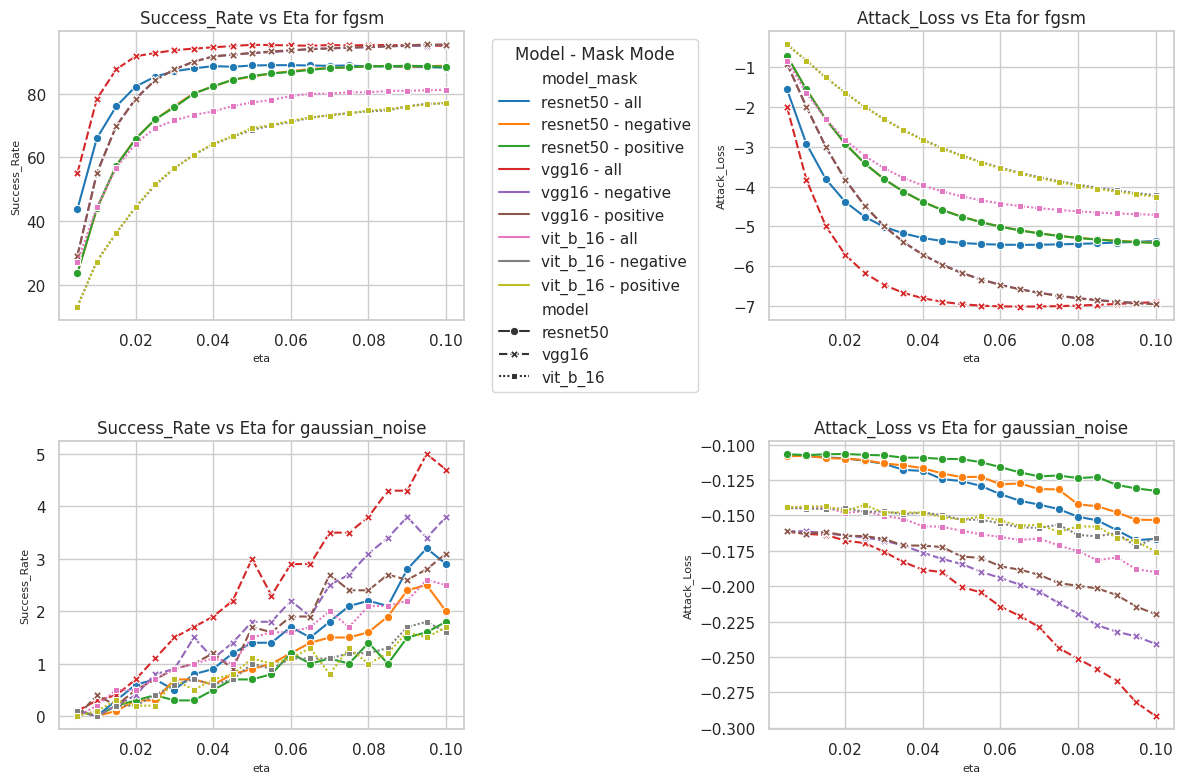

In [45]:
plot_success_rate_vs_eta(data1, algo_list=['fgsm', 'gaussian_noise'], var_list=['success_rate', 'attack_loss'], output_path=data_root, save_name='success_rate_vs_eta')

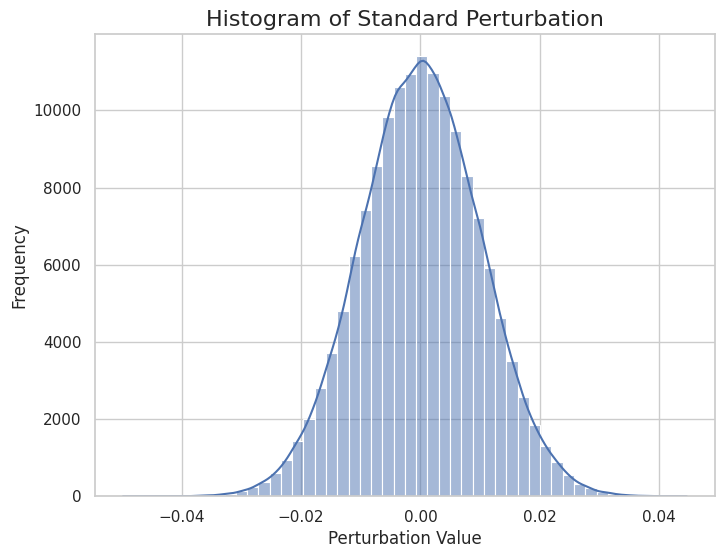

In [46]:
import torch
sigma = 0.01

standard_perturb = torch.randn_like(torch.randn(3, 224, 224)) * sigma
# 画出标准扰动的直方图
plt.figure(figsize=(8, 6))
sns.histplot(standard_perturb.flatten(), bins=50, kde=True)
plt.title('Histogram of Standard Perturbation', fontsize=16)
plt.xlabel('Perturbation Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

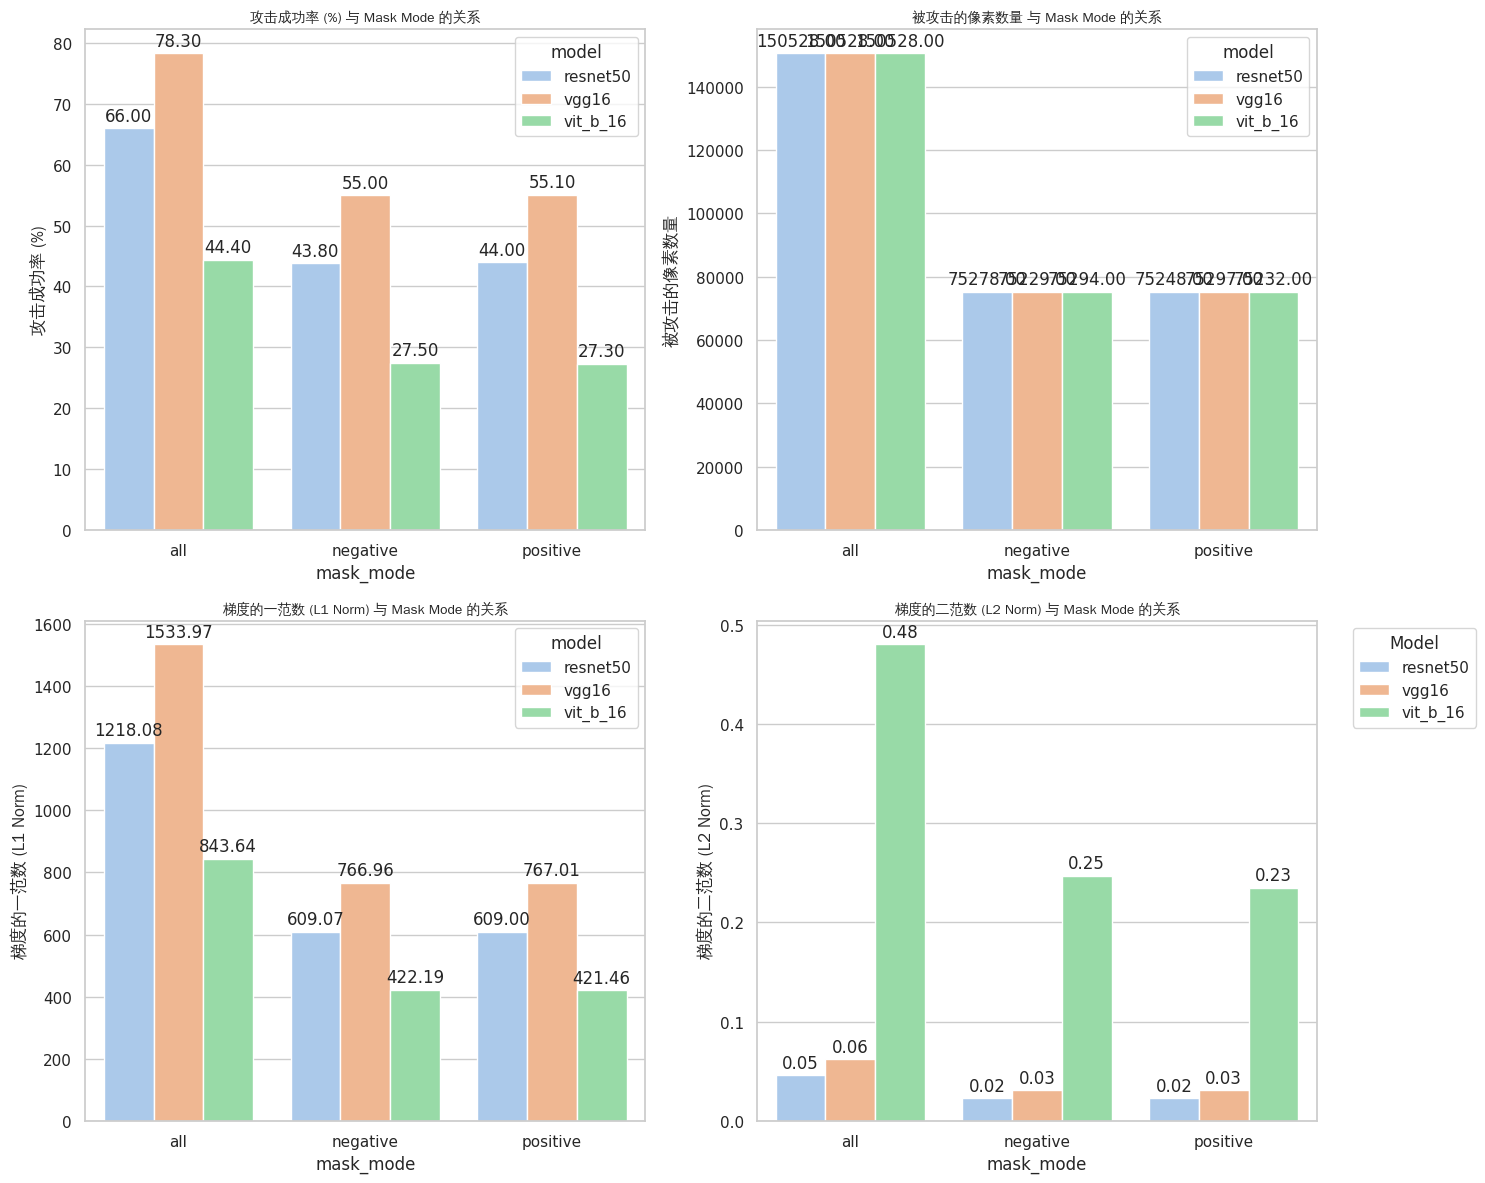

In [54]:
plot_success_rate_vs_norm(data1, 'fgsm', 0.01, output_path=data_root, save_name='success_rate_vs_norm')

/tmp/ipykernel_3286318/112815148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['algo&mask_mode'] = df_model['algo'] + '&' + df_model['mask_mode']
/tmp/ipykernel_3286318/112815148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['algo&mask_mode'] = df_model['algo'] + '&' + df_model['mask_mode']
/tmp/ipykernel_3286318/112815148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


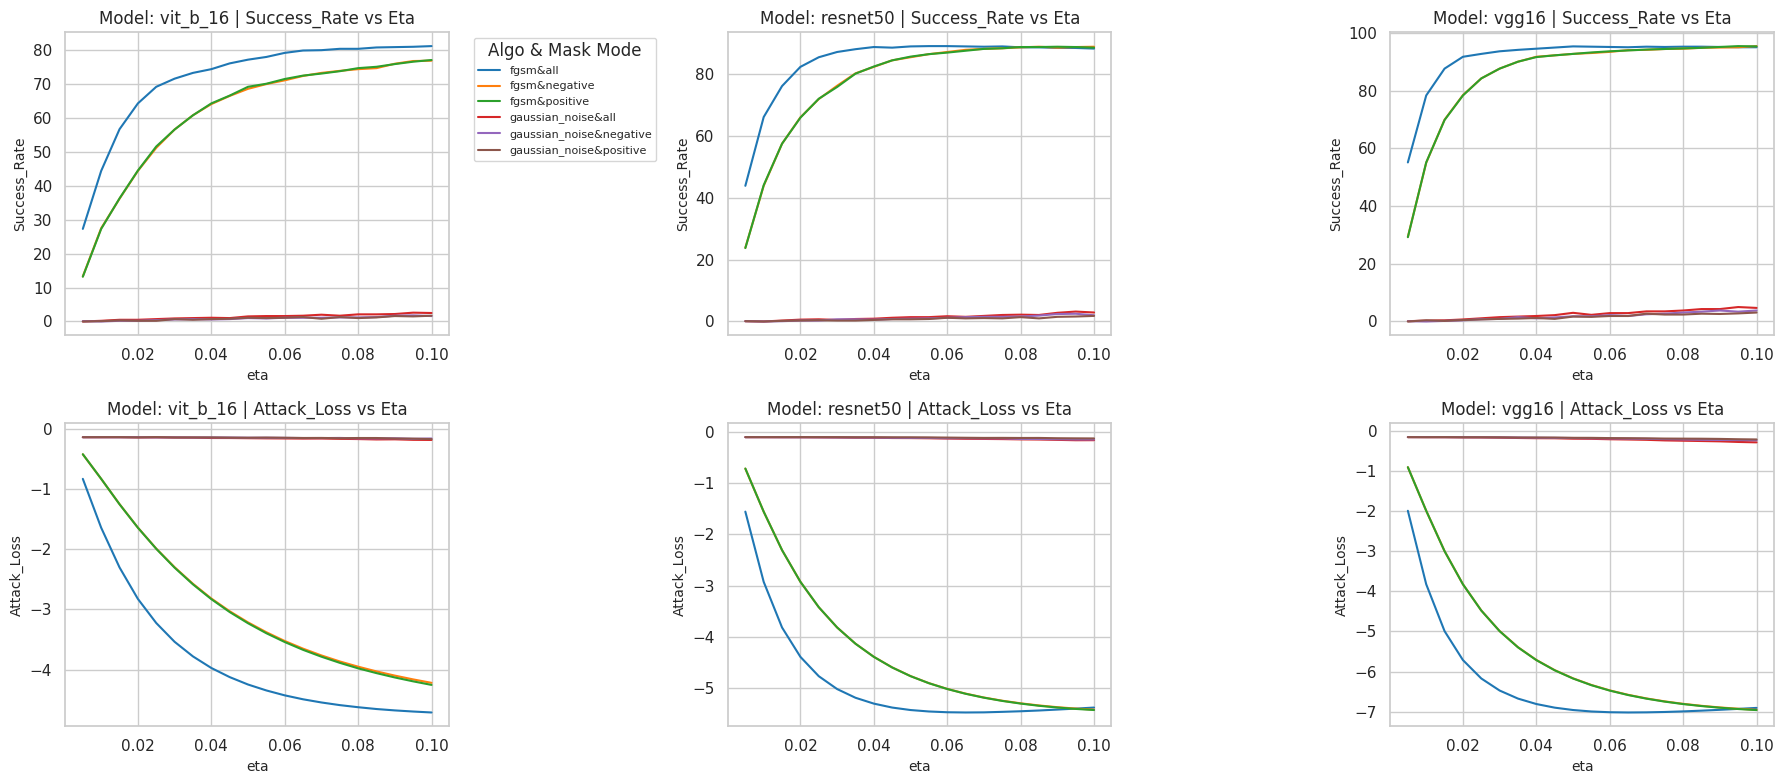

In [34]:
# plot_success_rate_vs_algo(data1, 'vit_b_16')
plot_success_rate_vs_algo(data1, model_list=['vit_b_16', 'resnet50', 'vgg16'], var_list=['success_rate', 'attack_loss'])

# 2. success_rate vs r
- 只考虑mask_mode in ('topr', 'cam_topr', 'randomr', 'cam_lowr', 'lowr')

In [7]:
data2 = data_grouped[data_grouped['mask_mode'].isin(['topr', 'cam_topr', 'randomr', 'cam_lowr', 'lowr'])]
data2.head()

model  algo mask_mode  parameter    eta  pixel_attacked  l1_norm  \
20  resnet50  fgsm  cam_lowr       0.01  0.005            1503   9.9452   
21  resnet50  fgsm  cam_lowr       0.01  0.010            1503   9.9452   
22  resnet50  fgsm  cam_lowr       0.01  0.015            1503   9.9452   
23  resnet50  fgsm  cam_lowr       0.01  0.020            1503   9.9452   
24  resnet50  fgsm  cam_lowr       0.01  0.025            1503   9.9452   

     l2_norm  original_loss  attack_loss  success_rate  run_time  \
20  0.000297        -0.1075      -0.1112         0.001    22.411   
21  0.000297        -0.1075      -0.1135         0.003    22.411   
22  0.000297        -0.1075      -0.1152         0.003    22.411   
23  0.000297        -0.1075      -0.1165         0.003    22.411   
24  0.000297        -0.1075      -0.1172         0.004    22.411   

    batch_pictures     R     G     B  
20            1000  0.01  0.01  0.01  
21            1000  0.01  0.01  0.01  
22            1000  0.01  0.01  0.01  
23            1000  0.01  0.01  0.01  
24            1000  0.01  0.01  0.01

In [8]:
def calculate_eta_reverse(row):
    if row['mask_mode'] in ('cam_lowr', 'lowr'):
        return 1 - row['parameter']
    else:
        return row['parameter']
data2.loc[:, 'r'] = data2.apply(calculate_eta_reverse, axis=1)
data2.head()

/tmp/ipykernel_3303792/2436078722.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[:, 'r'] = data2.apply(calculate_eta_reverse, axis=1)


model  algo mask_mode  parameter    eta  pixel_attacked  l1_norm  \
20  resnet50  fgsm  cam_lowr       0.01  0.005            1503   9.9452   
21  resnet50  fgsm  cam_lowr       0.01  0.010            1503   9.9452   
22  resnet50  fgsm  cam_lowr       0.01  0.015            1503   9.9452   
23  resnet50  fgsm  cam_lowr       0.01  0.020            1503   9.9452   
24  resnet50  fgsm  cam_lowr       0.01  0.025            1503   9.9452   

     l2_norm  original_loss  attack_loss  success_rate  run_time  \
20  0.000297        -0.1075      -0.1112         0.001    22.411   
21  0.000297        -0.1075      -0.1135         0.003    22.411   
22  0.000297        -0.1075      -0.1152         0.003    22.411   
23  0.000297        -0.1075      -0.1165         0.003    22.411   
24  0.000297        -0.1075      -0.1172         0.004    22.411   

    batch_pictures     R     G     B     r  
20            1000  0.01  0.01  0.01  0.99  
21            1000  0.01  0.01  0.01  0.99  
22            1000  0.01  0.01  0.01  0.99  
23            1000  0.01  0.01  0.01  0.99  
24            1000  0.01  0.01  0.01  0.99

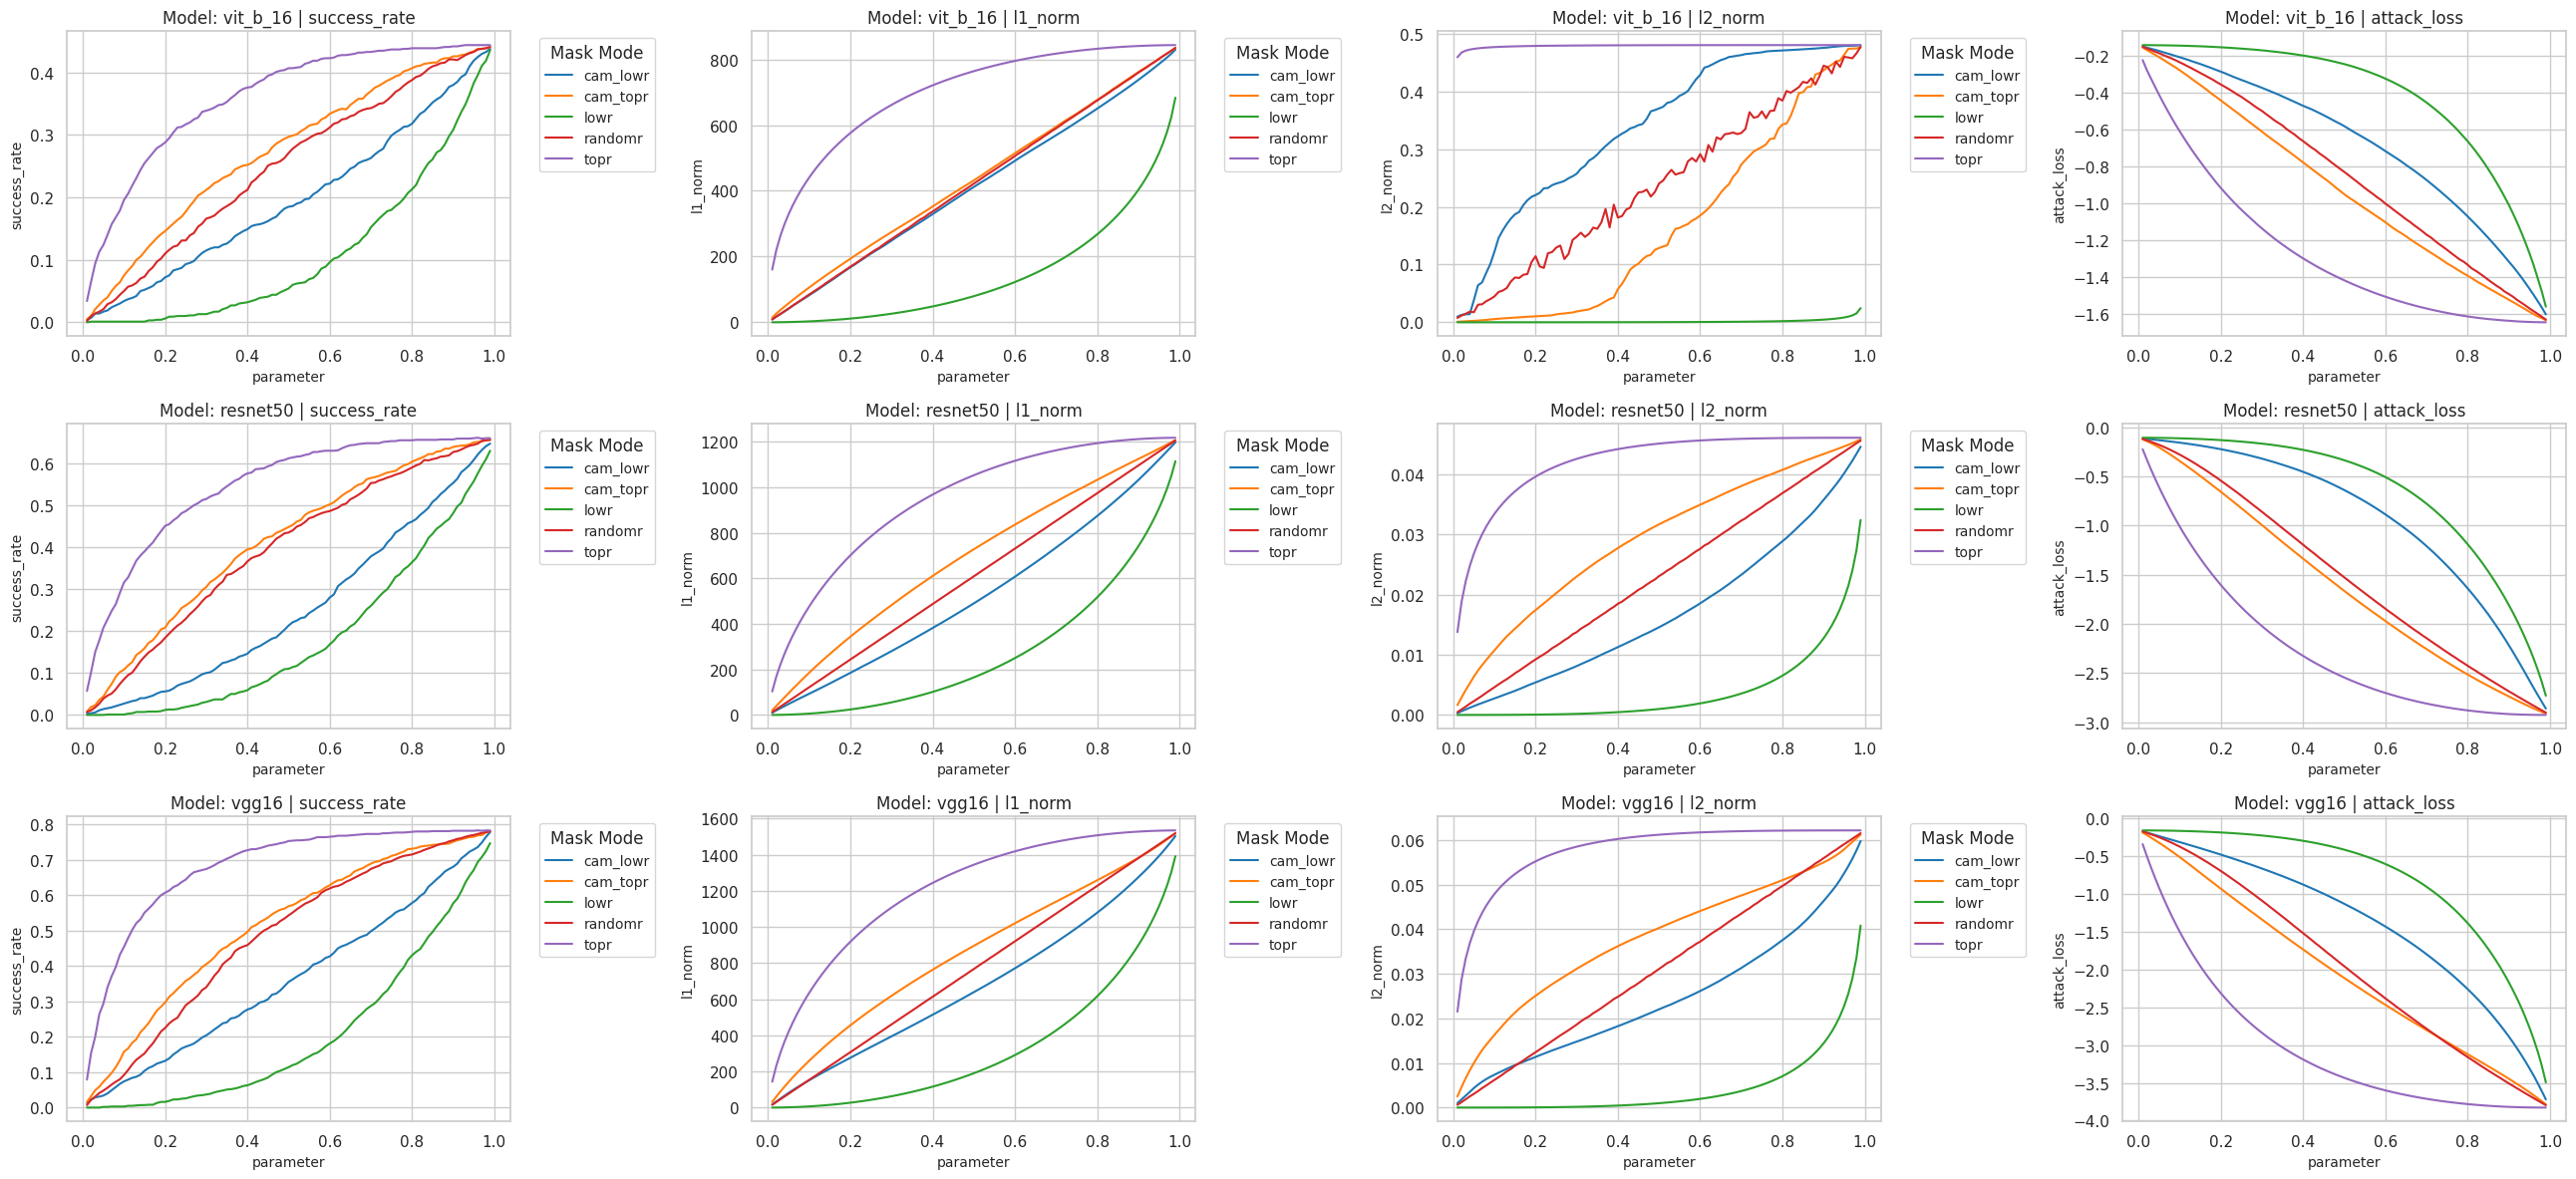

In [91]:
label_list = ['success_rate', 'l1_norm', 'l2_norm', 'attack_loss']
plot_success_rate_vs_r(data2, 0.01, 'fgsm', 'parameter', label_list, output_path=data_root, save_name='success_rate_vs_parameter')

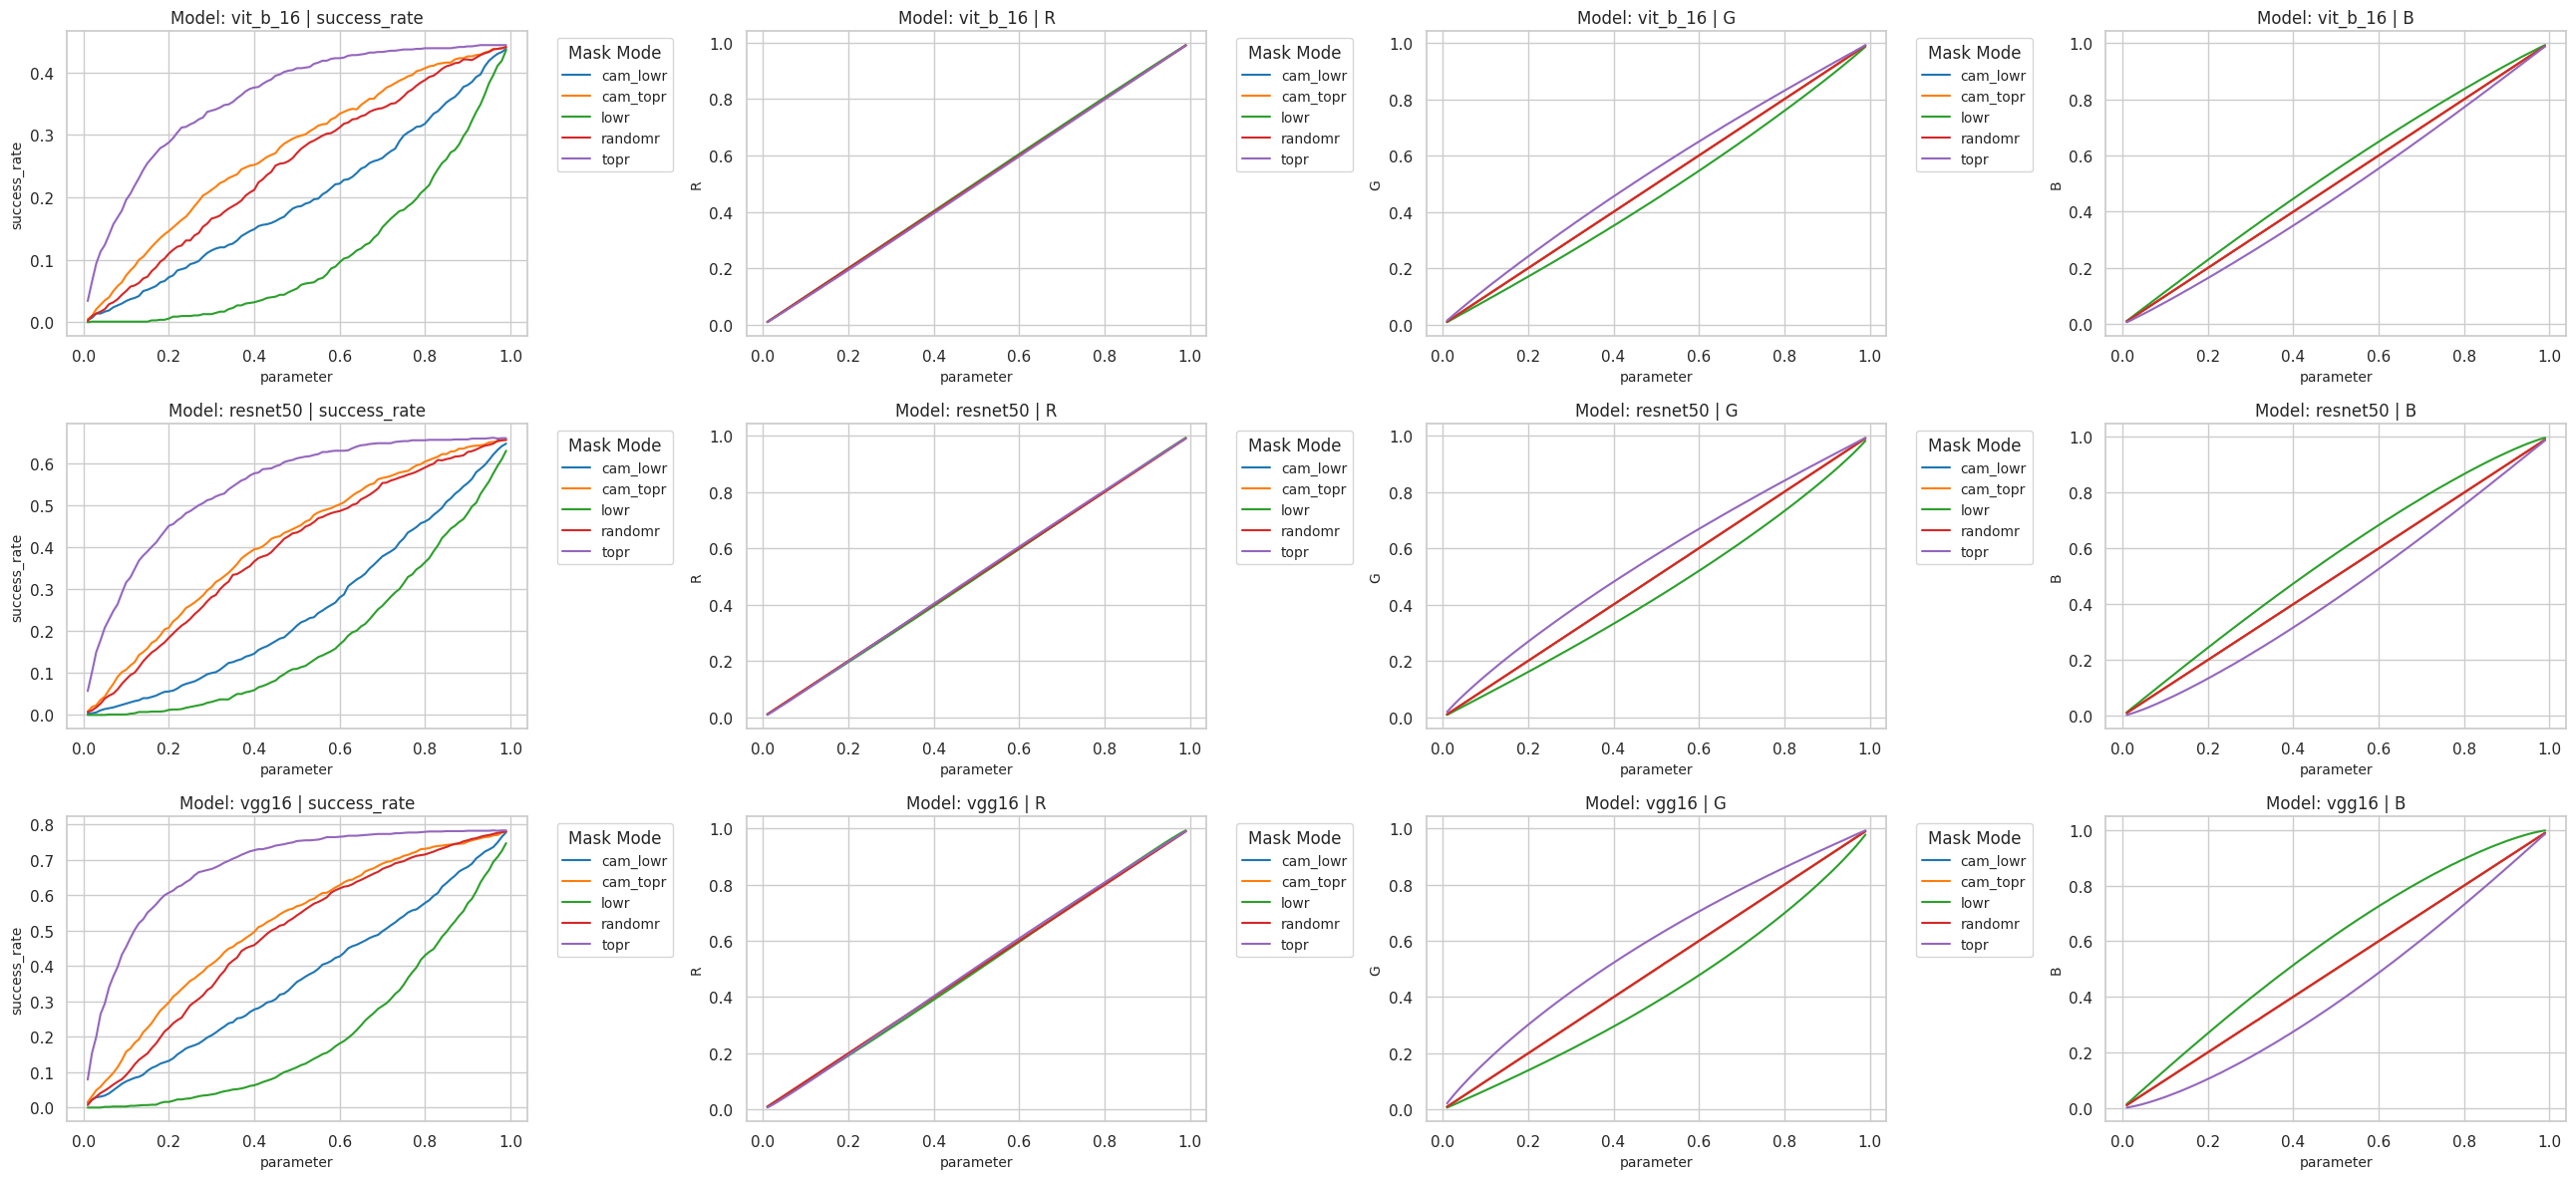

In [10]:
label_list = ['success_rate', 'R', 'G', 'B']
plot_success_rate_vs_r(data2, 0.01, 'fgsm', 'parameter', label_list, output_path=data_root, save_name='success_rate_vs_channel_ratio')

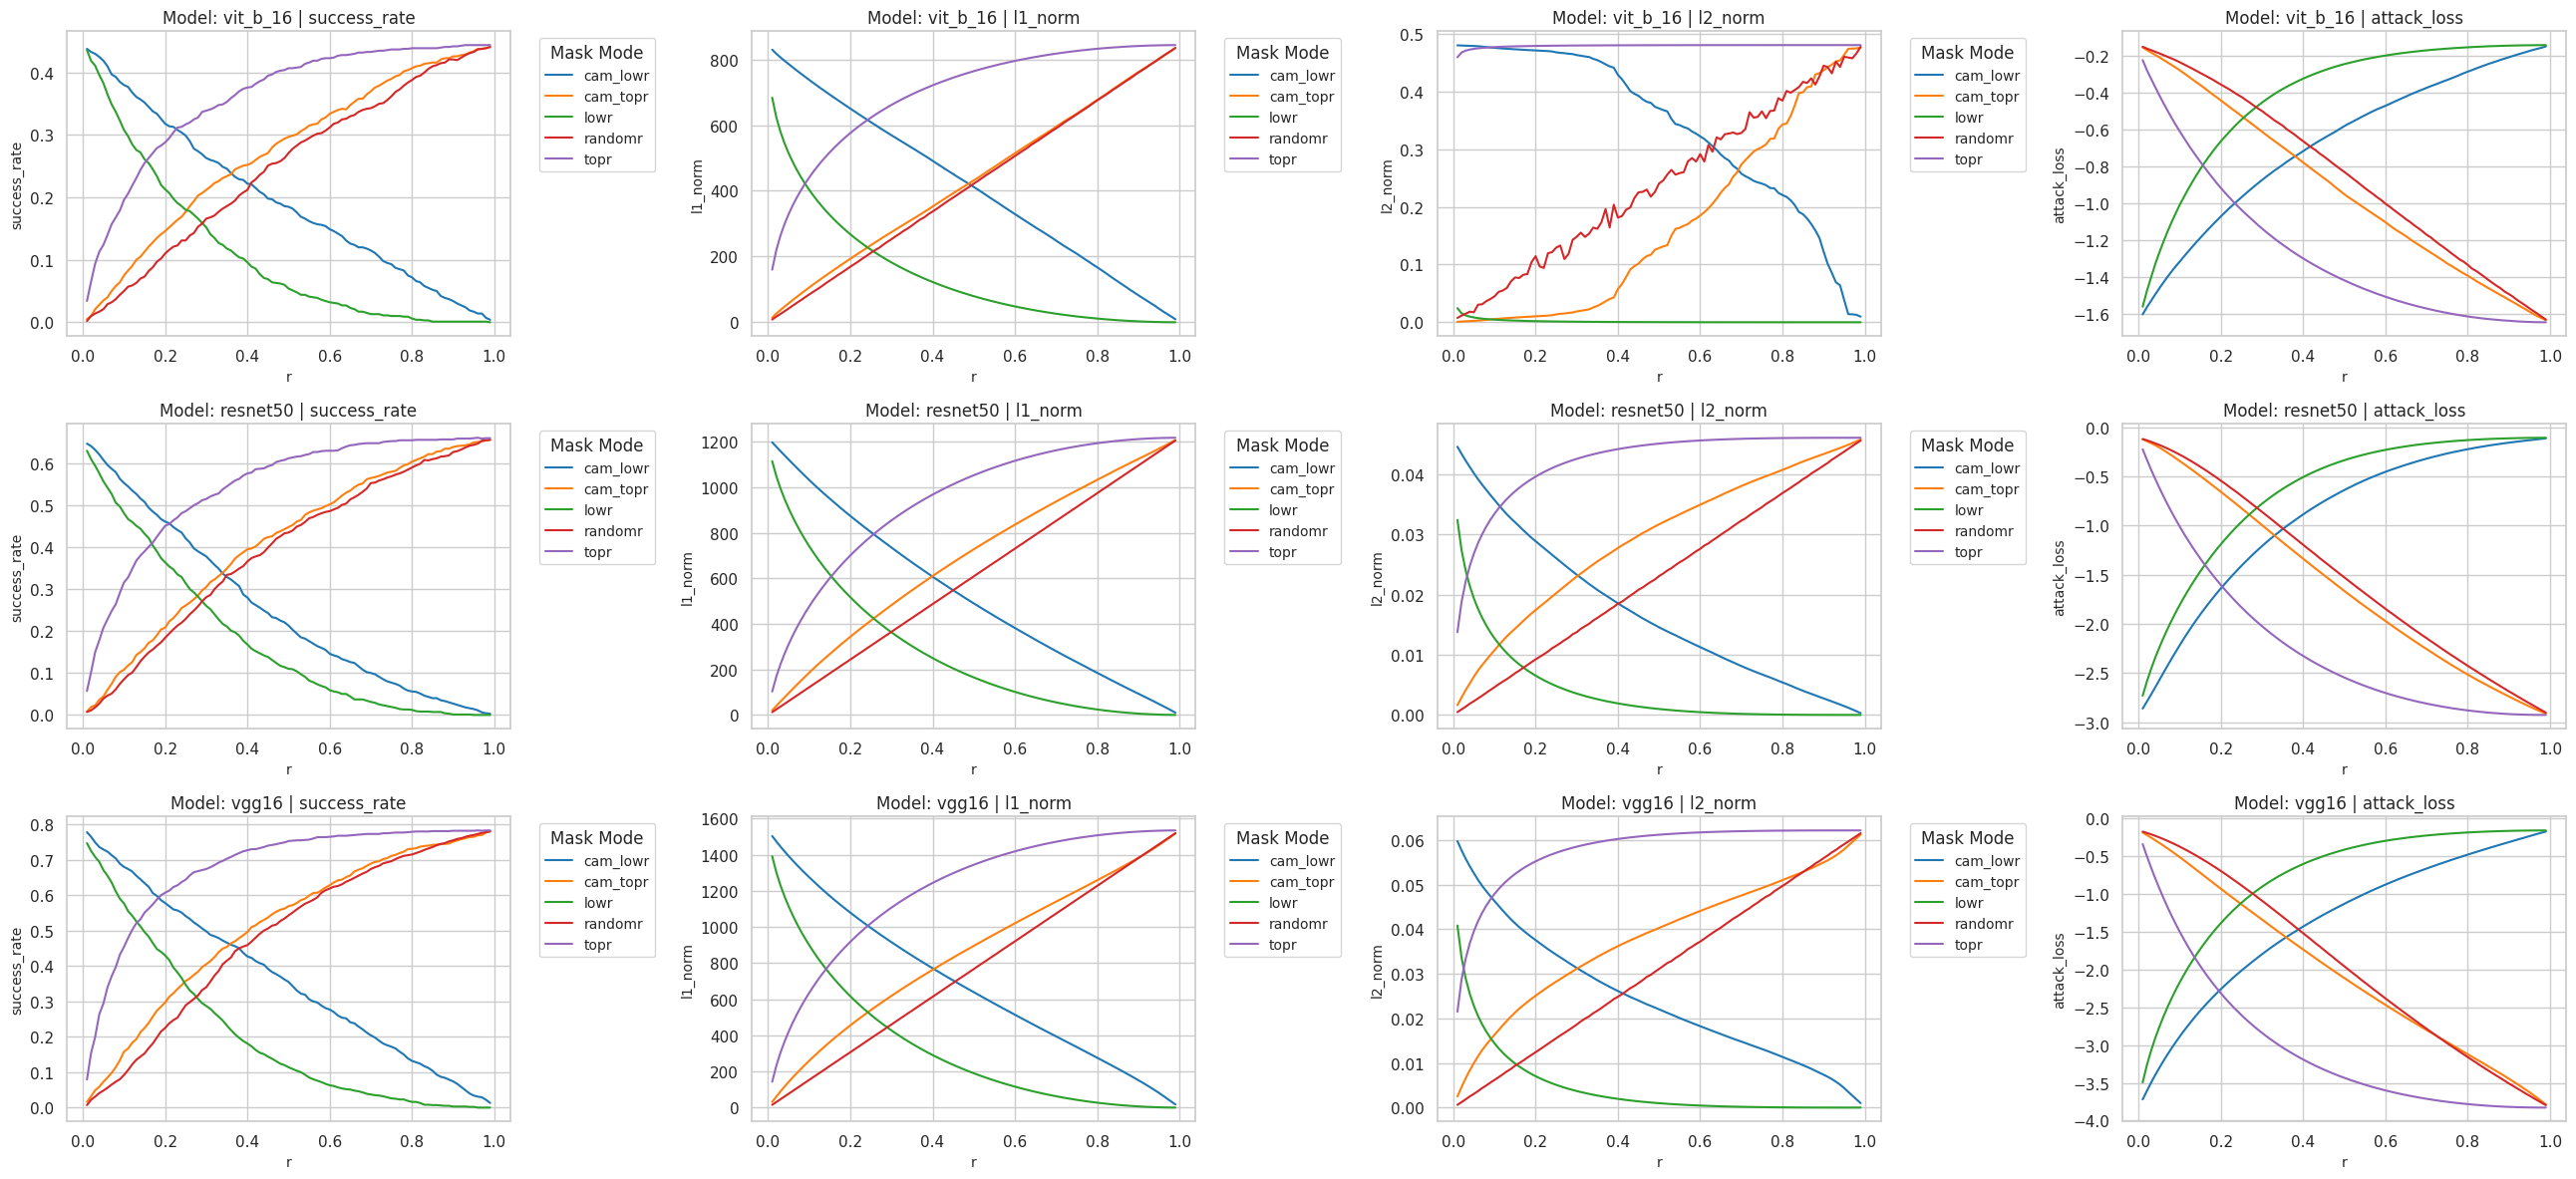

In [92]:
plot_success_rate_vs_r(data2, 0.01, 'fgsm', 'r', label_list, output_path=data_root, save_name='success_rate_vs_r_reverse')

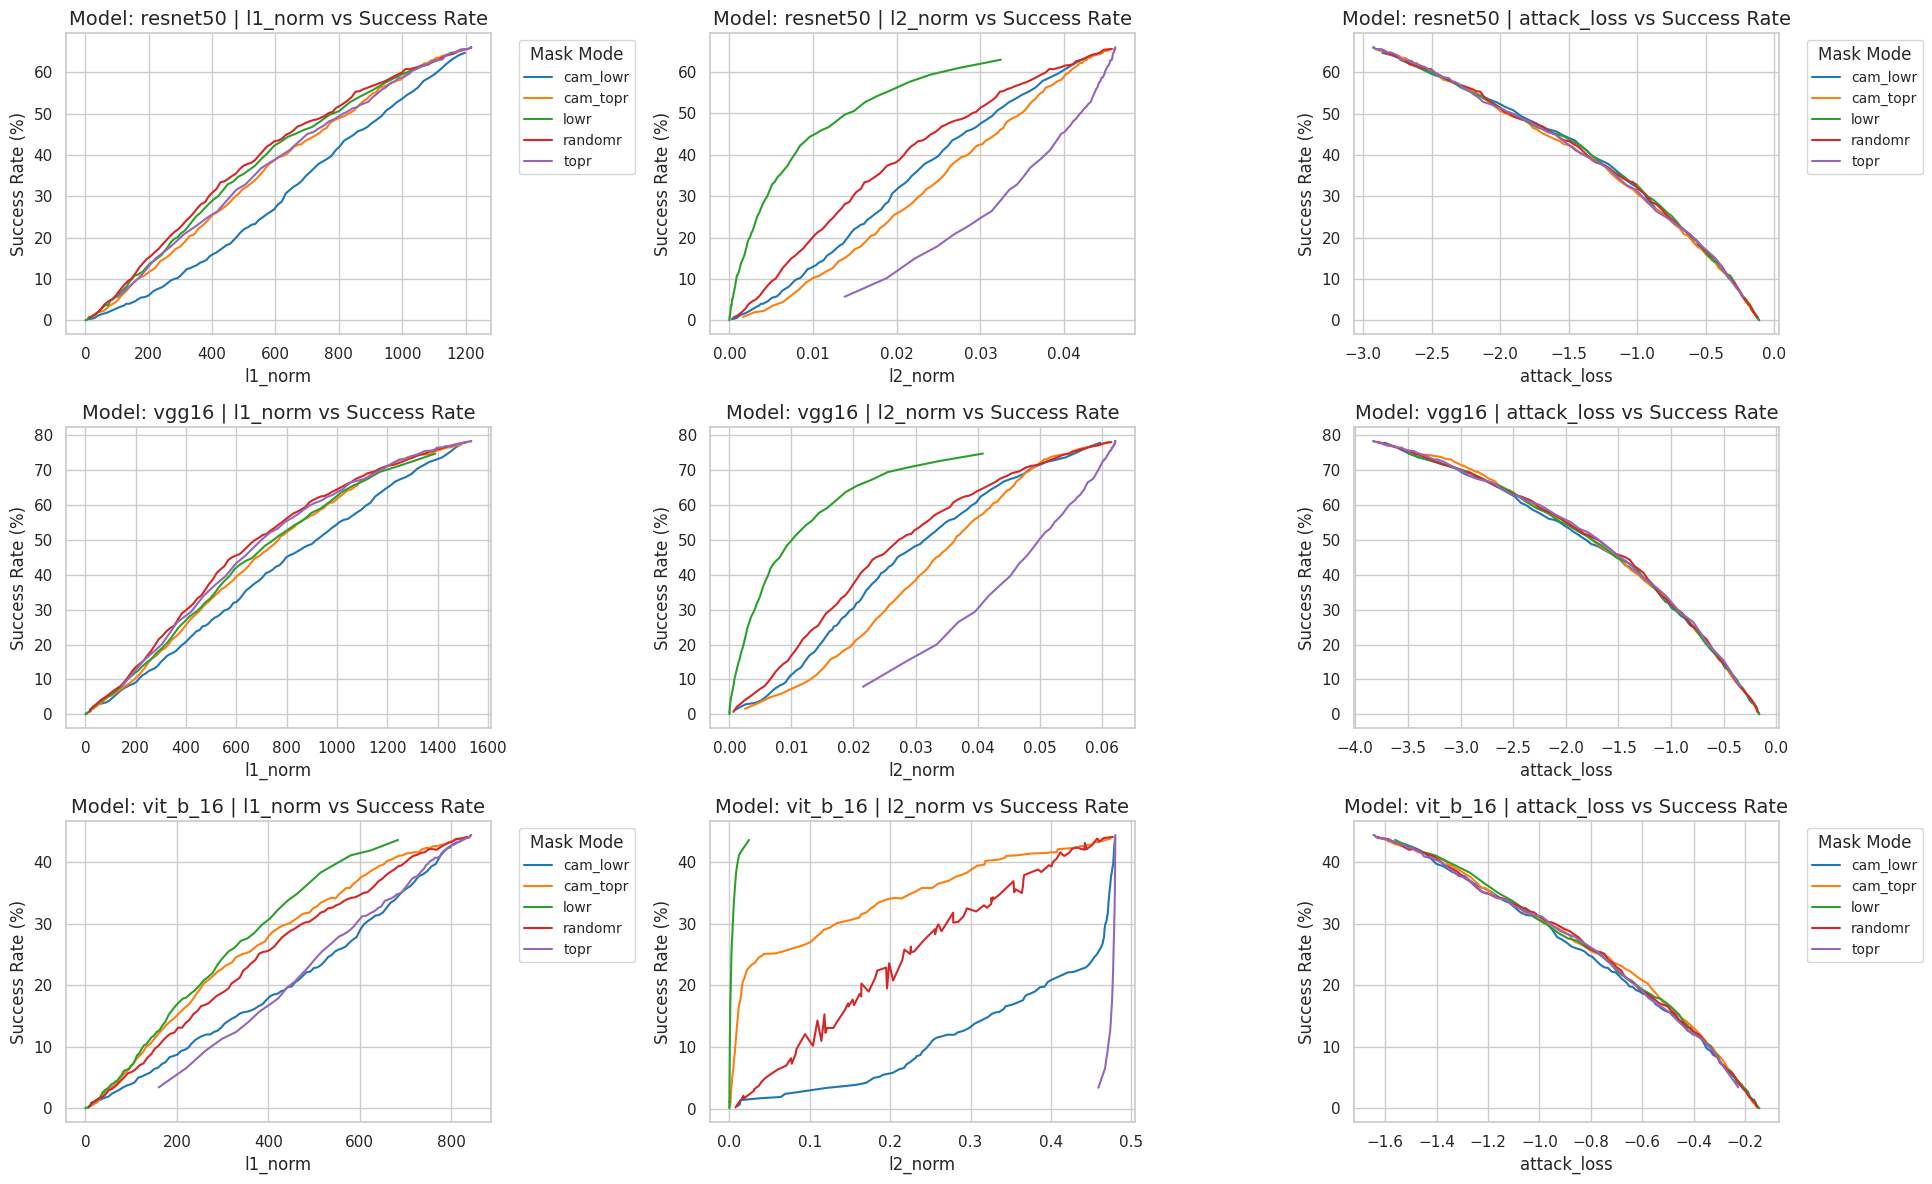

In [96]:
label_list = ['l1_norm', 'l2_norm', 'attack_loss']
plot_metrics_vs_success_rate_lines(data2, 0.01, 'fgsm', label_list, output_path=data_root, save_name='metrics_vs_success_rate_lines')

In [41]:
plot_3d_scatter_plotly(data2, 0.01, 'fgsm', 'l1_norm')

In [42]:
plot_3d_scatter_plotly(data2, 0.01, 'fgsm', 'l2_norm')